Charging strategy: GENERATION
Strategy status:   ACTIVE
Verwendetes Szenario: office
Vorhandene Ladepunkte am Standort: 10
Erster Timestamp: 2025-12-01 00:00:00
Letzter Timestamp: 2025-12-14 23:45:00
Simulationshorizont: 14 Tage
Kalenderische Tage je Tagtyp:
- working_day: 10 Tage
- saturday: 2 Tage
- sunday_holiday: 2 Tage

Anzahl Ladesessions im Simulationshorizont: 499
Max. gleichzeitig ladende Fahrzeuge: 10

Beispiel-Sessions (erste 10):
Fahrzeug: EQS, Ankunft: 2025-12-01 06:27:14.158267, Abfahrt: 2025-12-01 12:54:46.509571, Kapazität: 118.0 kWh, geladene Energie: 55.0 kWh, Restbedarf: 0.0 kWh
Fahrzeug: Model Y, Ankunft: 2025-12-01 06:45:15.030946, Abfahrt: 2025-12-01 13:25:55.636435, Kapazität: 65.0 kWh, geladene Energie: 51.1 kWh, Restbedarf: 0.0 kWh
Fahrzeug: 1# Pro Plus, Ankunft: 2025-12-01 06:52:42.803258, Abfahrt: 2025-12-01 14:47:51.794927, Kapazität: 66.0 kWh, geladene Energie: 13.6 kWh, Restbedarf: 0.0 kWh
Fahrzeug: iX xDrive50, Ankunft: 2025-12-01 06:58:00.914342, Abfahrt

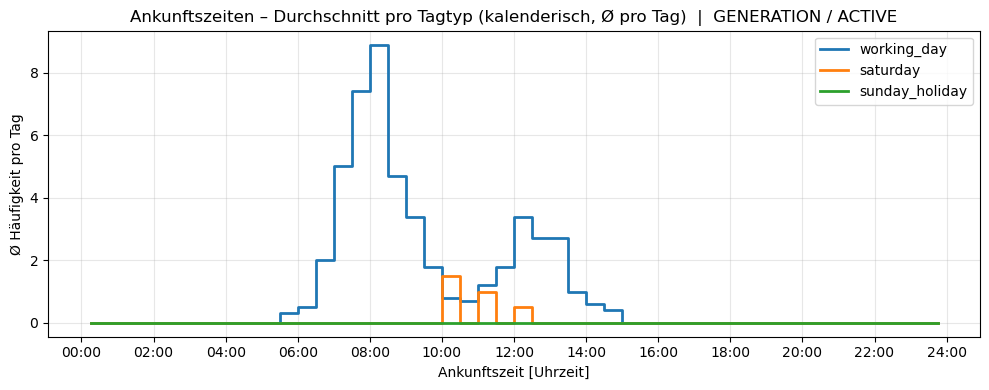

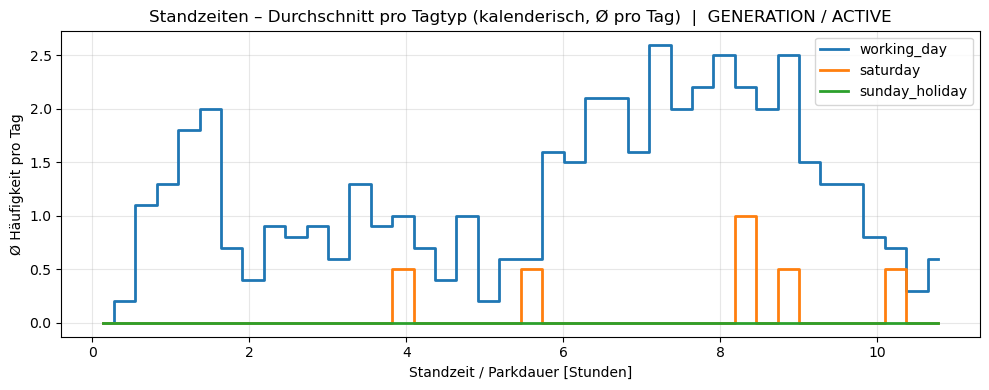

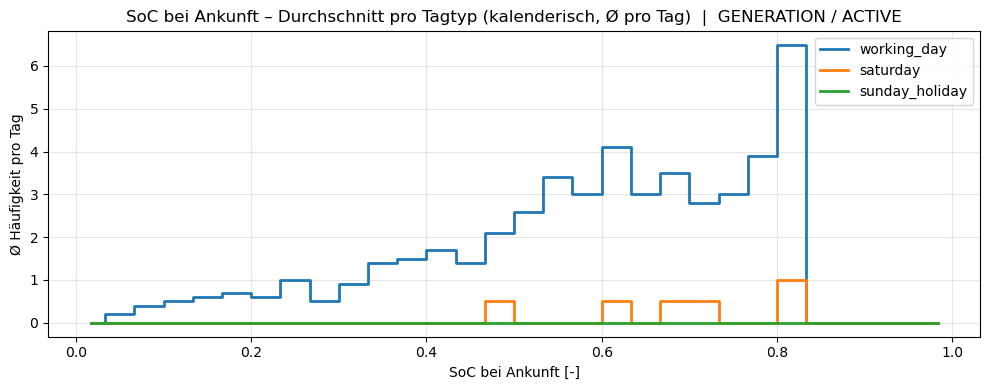

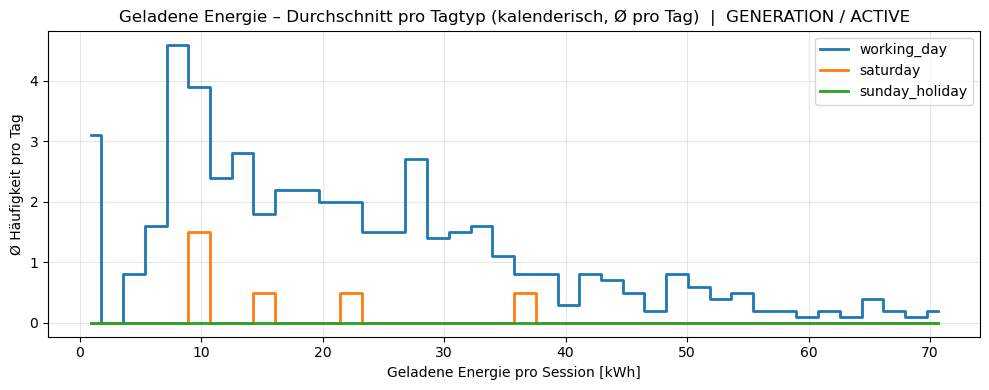

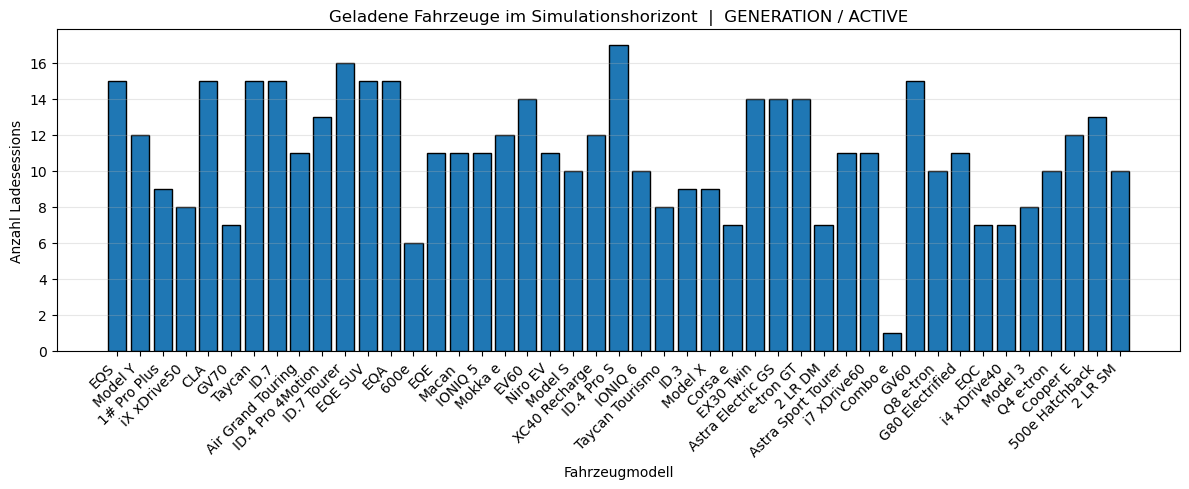

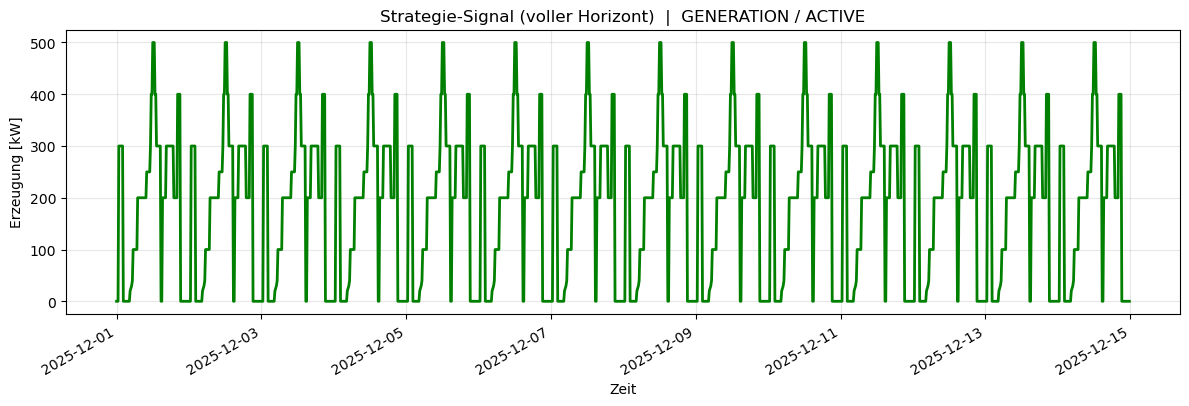

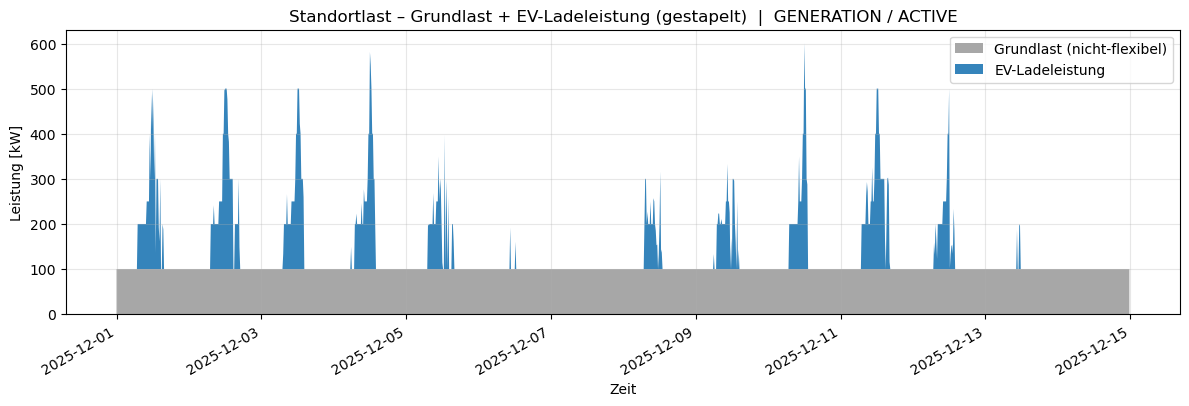

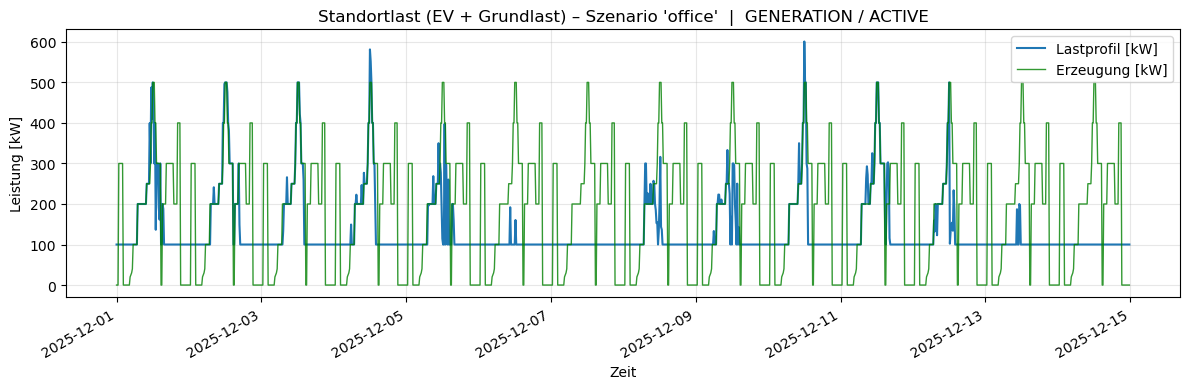

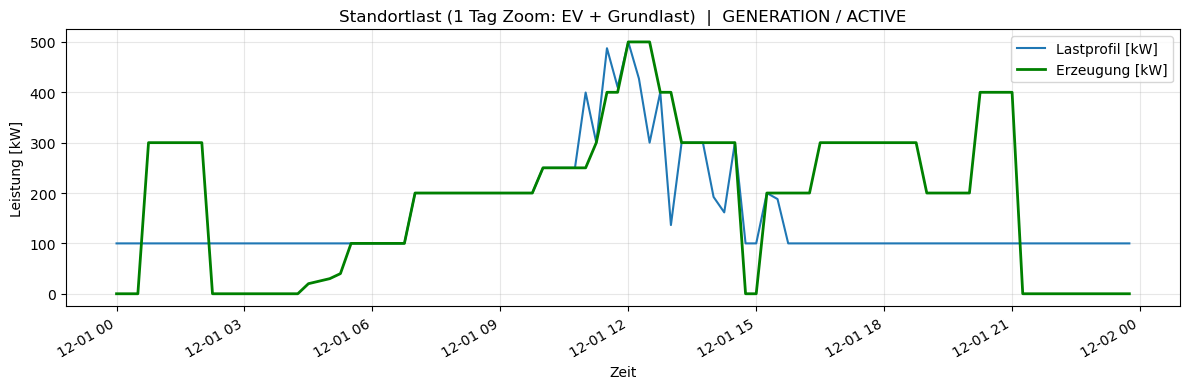


DEBUG – Netzbezug-Auswertung
Genutzte Netzimport-Spalte: grid_import_kw_site
Anzahl Debug-Zeilen insgesamt (nach Tagfilter ggf.): 243
Anzahl Debug-Zeilen mit Netzbezug: 30
Anzahl Zeitschritte mit Netzbezug: 3


ts
2025-12-01 11:00:00    149.557265
2025-12-01 11:30:00     87.497026
2025-12-01 11:45:00     10.316140
Name: grid_import_kw_site, dtype: float64


=== Netzbezug-Zeitschritt: 2025-12-01 11:00:00 ===


,ts,vehicle_name,arrival_time,departure_time,parking_hours,slack_minutes,is_emergency,pv_kw,base_kw,pv_surplus_kw,site_total_power_kw,grid_import_kw_site,has_any_emergency_this_step
151,2025-12-01 11:00:00,EQA,2025-12-01 07:44:49.567935,2025-12-01 11:08:24.904111,3.393149,-14.857036,True,250.0,100.0,150.0,299.557265,149.557265,True
152,2025-12-01 11:00:00,ID.7 Tourer,2025-12-01 07:37:28.740752,2025-12-01 11:05:03.629047,3.459691,-2.373106,True,250.0,100.0,150.0,299.557265,149.557265,True
153,2025-12-01 11:00:00,EQS,2025-12-01 06:27:14.158267,2025-12-01 12:54:46.509571,6.458986,109.464390,False,250.0,100.0,150.0,299.557265,149.557265,True
154,2025-12-01 11:00:00,GV70,2025-12-01 07:56:18.259523,2025-12-01 13:22:26.362204,5.435584,114.081614,False,250.0,100.0,150.0,299.557265,149.557265,True
155,2025-12-01 11:00:00,EQE,2025-12-01 07:53:10.084381,2025-12-01 13:43:12.481129,5.833999,130.311872,False,250.0,100.0,150.0,299.557265,149.557265,True
156,2025-12-01 11:00:00,Model Y,2025-12-01 06:45:15.030946,2025-12-01 13:25:55.636435,6.677946,141.988477,False,250.0,100.0,150.0,299.557265,149.557265,True
157,2025-12-01 11:00:00,EQE SUV,2025-12-01 07:38:51.550171,2025-12-01 14:10:29.948590,6.527333,171.620299,False,250.0,100.0,150.0,299.557265,149.557265,True
158,2025-12-01 11:00:00,ID.7,2025-12-01 07:18:36.433525,2025-12-01 15:44:27.007329,8.430715,280.676210,False,250.0,100.0,150.0,299.557265,149.557265,True
159,2025-12-01 11:00:00,GV70,2025-12-01 07:56:18.836938,2025-12-01 16:27:53.816543,8.526383,321.133337,False,250.0,100.0,150.0,299.557265,149.557265,True
160,2025-12-01 11:00:00,600e,2025-12-01 07:46:55.695179,2025-12-01 17:22:07.122614,9.586508,377.417778,False,250.0,100.0,150.0,299.557265,149.557265,True



=== Netzbezug-Zeitschritt: 2025-12-01 11:30:00 ===


,ts,vehicle_name,arrival_time,departure_time,parking_hours,slack_minutes,is_emergency,pv_kw,base_kw,pv_surplus_kw,site_total_power_kw,grid_import_kw_site,has_any_emergency_this_step
169,2025-12-01 11:30:00,EV60,2025-12-01 08:06:34.904857,2025-12-01 11:41:33.195283,3.582858,-3.130739,True,400.0,100.0,300.0,387.497026,87.497026,True
170,2025-12-01 11:30:00,IONIQ 5,2025-12-01 08:00:13.631575,2025-12-01 11:49:17.863369,3.817842,12.750302,True,400.0,100.0,300.0,387.497026,87.497026,True
171,2025-12-01 11:30:00,Taycan,2025-12-01 08:10:40.538459,2025-12-01 12:02:53.893433,3.870376,24.502364,True,400.0,100.0,300.0,387.497026,87.497026,True
172,2025-12-01 11:30:00,GV70,2025-12-01 07:56:18.259523,2025-12-01 13:22:26.362204,5.435584,92.881804,False,400.0,100.0,300.0,387.497026,87.497026,True
173,2025-12-01 11:30:00,EQE,2025-12-01 07:53:10.084381,2025-12-01 13:43:12.481129,5.833999,109.112062,False,400.0,100.0,300.0,387.497026,87.497026,True
174,2025-12-01 11:30:00,Niro EV,2025-12-01 08:13:53.076003,2025-12-01 14:00:48.960632,5.782190,110.288568,False,400.0,100.0,300.0,387.497026,87.497026,True
175,2025-12-01 11:30:00,EQE SUV,2025-12-01 07:38:51.550171,2025-12-01 14:10:29.948590,6.527333,147.663866,False,400.0,100.0,300.0,387.497026,87.497026,True
176,2025-12-01 11:30:00,XC40 Recharge,2025-12-01 08:22:06.976777,2025-12-01 14:53:28.625930,6.522680,188.211278,False,400.0,100.0,300.0,387.497026,87.497026,True
177,2025-12-01 11:30:00,Model S,2025-12-01 08:21:18.035017,2025-12-01 16:03:29.460288,7.703174,251.724686,False,400.0,100.0,300.0,387.497026,87.497026,True
178,2025-12-01 11:30:00,ID.4 Pro S,2025-12-01 09:21:39.598857,2025-12-01 16:05:44.480449,6.734689,258.024497,False,400.0,100.0,300.0,387.497026,87.497026,True



=== Netzbezug-Zeitschritt: 2025-12-01 11:45:00 ===


,ts,vehicle_name,arrival_time,departure_time,parking_hours,slack_minutes,is_emergency,pv_kw,base_kw,pv_surplus_kw,site_total_power_kw,grid_import_kw_site,has_any_emergency_this_step
179,2025-12-01 11:45:00,IONIQ 5,2025-12-01 08:00:13.631575,2025-12-01 11:49:17.863369,3.817842,2.750302,True,400.0,100.0,300.0,310.31614,10.31614,True
180,2025-12-01 11:45:00,Taycan,2025-12-01 08:10:40.538459,2025-12-01 12:02:53.893433,3.870376,13.663073,True,400.0,100.0,300.0,310.31614,10.31614,True
181,2025-12-01 11:45:00,GV70,2025-12-01 07:56:18.259523,2025-12-01 13:22:26.362204,5.435584,82.289170,False,400.0,100.0,300.0,310.31614,10.31614,True
182,2025-12-01 11:45:00,EQE,2025-12-01 07:53:10.084381,2025-12-01 13:43:12.481129,5.833999,99.112062,False,400.0,100.0,300.0,310.31614,10.31614,True
183,2025-12-01 11:45:00,Niro EV,2025-12-01 08:13:53.076003,2025-12-01 14:00:48.960632,5.782190,107.742823,False,400.0,100.0,300.0,310.31614,10.31614,True
184,2025-12-01 11:45:00,EQE SUV,2025-12-01 07:38:51.550171,2025-12-01 14:10:29.948590,6.527333,135.100715,False,400.0,100.0,300.0,310.31614,10.31614,True
185,2025-12-01 11:45:00,XC40 Recharge,2025-12-01 08:22:06.976777,2025-12-01 14:53:28.625930,6.522680,177.529114,False,400.0,100.0,300.0,310.31614,10.31614,True
186,2025-12-01 11:45:00,Model S,2025-12-01 08:21:18.035017,2025-12-01 16:03:29.460288,7.703174,241.724686,False,400.0,100.0,300.0,310.31614,10.31614,True
187,2025-12-01 11:45:00,ID.4 Pro S,2025-12-01 09:21:39.598857,2025-12-01 16:05:44.480449,6.734689,248.024497,False,400.0,100.0,300.0,310.31614,10.31614,True
188,2025-12-01 11:45:00,ID.4 Pro 4Motion,2025-12-01 09:42:10.174169,2025-12-01 19:02:38.193685,9.341117,430.456675,False,400.0,100.0,300.0,310.31614,10.31614,True



🔎 Zeitschritte mit ungenutztem PV-Strom: 56


,ts,pv_surplus_kw,site_power_kw,grid_import_kw,n_sessions,pv_unused_kw
21,2025-12-01 12:15:00,400.0,327.067935,0.0,8,72.932065
22,2025-12-01 12:30:00,400.0,200.000000,0.0,2,200.000000
24,2025-12-01 13:00:00,300.0,36.412733,0.0,2,263.587267
28,2025-12-01 14:00:00,200.0,92.238598,0.0,1,107.761402
29,2025-12-01 14:15:00,200.0,61.562556,0.0,1,138.437444
32,2025-12-01 15:30:00,100.0,87.995723,0.0,3,12.004277
69,2025-12-02 16:45:00,200.0,49.025682,0.0,3,150.974318
70,2025-12-03 07:15:00,100.0,33.684211,0.0,1,66.315789
97,2025-12-03 14:00:00,200.0,159.084942,0.0,4,40.915058
125,2025-12-04 13:45:00,200.0,96.756177,0.0,2,103.243823


→ Fahrzeuge mit Restbedarf: (nicht verfügbar – energy_required_kwh wurde nicht geloggt)


In [ ]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from collections import Counter, defaultdict
from datetime import datetime, timedelta, date

warnings.simplefilter("always", UserWarning)
from IPython.display import display, HTML


# =============================================================================
# 0) Notebook-UI Helpers
# =============================================================================

def show_strategy_status_html(charging_strategy: str, strategy_status: str) -> None:
    status = (strategy_status or "IMMEDIATE").upper()
    strat = (charging_strategy or "immediate").upper()

    color_map = {
        "ACTIVE": "#1a7f37",
        "INACTIVE": "#c62828",
        "IMMEDIATE": "#616161",
    }
    emoji_map = {
        "ACTIVE": "🟢",
        "INACTIVE": "🔴",
        "IMMEDIATE": "⚪",
    }

    color = color_map.get(status, "#616161")
    emoji = emoji_map.get(status, "⚪")

    html = f"""
    <div style="
        font-size:18px; font-weight:800; color:{color};
        padding:10px 12px; border:2px solid {color};
        border-radius:12px; display:flex; align-items:center;
        gap:10px; width:fit-content; margin:8px 0 14px 0;
        background: rgba(0,0,0,0.02);
    ">
      <span style="font-size:22px">{emoji}</span>
      <div>
        <div>Charging strategy: <span style="letter-spacing:0.5px">{strat}</span></div>
        <div>Strategy status: <span style="letter-spacing:0.5px">{status}</span></div>
      </div>
    </div>
    """
    display(HTML(html))


def decorate_title_with_status(base_title: str, charging_strategy: str, strategy_status: str) -> str:
    status = (strategy_status or "IMMEDIATE").upper()
    strat = (charging_strategy or "immediate").upper()
    return f"{base_title}  |  {strat} / {status}"


# =============================================================================
# 1) Projektpfad setzen, damit "model" importierbar ist
# =============================================================================

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

from model.simulation import (
    load_scenario,
    simulate_load_profile,
    build_strategy_signal_series,   # ✅ aus simulation.py
)


# =============================================================================
# 2) Szenario laden und Simulation durchführen
# =============================================================================

scenario_name = "office"
scenario_path = f"../scenarios/{scenario_name}.yaml"
scenario = load_scenario(scenario_path)

try:
    timestamps, load_kw, sessions, charging_counts, holiday_dates, charging_strategy, strategy_status, debug_rows = (
        simulate_load_profile(scenario, record_debug=True)
    )
except ValueError as e:
    print("\n❌ Simulation abgebrochen:\n")
    print(str(e))
    timestamps = load_kw = sessions = charging_counts = holiday_dates = None
    charging_strategy = strategy_status = None
    debug_rows = None

if charging_strategy is not None and strategy_status is not None:
    show_strategy_status_html(charging_strategy, strategy_status)
    print(f"Charging strategy: {charging_strategy.upper()}")
    print(f"Strategy status:   {strategy_status}")


# =============================================================================
# 2b) Strategie-Signalreihe (aligned) + Labels
# =============================================================================

strategy_series = None
strategy_ylabel = None

if timestamps is not None and charging_strategy is not None:
    if charging_strategy.lower() in ("market", "generation"):
        # normalize_to_internal=True:
        #   market -> €/kWh, generation -> kW
        strategy_series, strategy_ylabel = build_strategy_signal_series(
            scenario=scenario,
            timestamps=timestamps,
            charging_strategy=charging_strategy,
            normalize_to_internal=True,
            strategy_resolution_min=15,
        )


# =============================================================================
# 3) Kontrollen
# =============================================================================

if timestamps is not None:
    print("Verwendetes Szenario:", scenario_name)
    print("Vorhandene Ladepunkte am Standort:", scenario["site"]["number_chargers"])
    print(f"Erster Timestamp: {timestamps[0]}")
    print(f"Letzter Timestamp: {timestamps[-1]}")
    print(f"Simulationshorizont: {scenario['simulation_horizon_days']} Tage")


# =============================================================================
# 4) Day-Type-Logik lokal im Notebook
# =============================================================================

def determine_day_type_notebook(dt, holiday_dates):
    d = dt.date()
    if d in holiday_dates:
        return "sunday_holiday"
    wd = dt.weekday()  # Mo=0 ... So=6
    if wd == 6:
        return "sunday_holiday"
    if wd == 5:
        return "saturday"
    return "working_day"


# =============================================================================
# 5) Feature-Helper pro Session
# =============================================================================

def minutes_since_midnight(dt):
    return dt.hour * 60 + dt.minute + dt.second / 60.0

def feat_arrival_hours(s):
    return minutes_since_midnight(s["arrival_time"]) / 60.0

def feat_parking_hours(s):
    return (s["departure_time"] - s["arrival_time"]).total_seconds() / 3600.0

def feat_soc_arrival(s):
    return float(s["soc_arrival"])

def feat_delivered_kwh(s):
    return float(s.get("delivered_energy_kwh", 0.0))


# =============================================================================
# 6) Tage kalendarisch zählen
# =============================================================================

if timestamps is not None:
    start_dt = datetime.fromisoformat(scenario["start_datetime"])
    horizon_days = int(scenario["simulation_horizon_days"])
    all_days = [start_dt.date() + timedelta(days=i) for i in range(horizon_days)]

    days_by_type_calendar = defaultdict(list)
    for d in all_days:
        dt_midday = datetime(d.year, d.month, d.day, 12, 0)
        day_type = determine_day_type_notebook(dt_midday, holiday_dates)
        days_by_type_calendar[day_type].append(d)

    print("Kalenderische Tage je Tagtyp:")
    for k in ["working_day", "saturday", "sunday_holiday"]:
        print(f"- {k}: {len(days_by_type_calendar.get(k, []))} Tage")


# =============================================================================
# 7) Kontrollen: Sessions
# =============================================================================

if sessions is not None:
    print("\nAnzahl Ladesessions im Simulationshorizont:", len(sessions))
    print("Max. gleichzeitig ladende Fahrzeuge:", max(charging_counts) if charging_counts else 0)

    print("\nBeispiel-Sessions (erste 10):")
    for s in sessions[:10]:
        print(
            f"Fahrzeug: {s['vehicle_name']}, "
            f"Ankunft: {s['arrival_time']}, "
            f"Abfahrt: {s['departure_time']}, "
            f"Kapazität: {s['battery_capacity_kwh']} kWh, "
            f"geladene Energie: {s['delivered_energy_kwh']:.1f} kWh, "
            f"Restbedarf: {s['energy_required_kwh']:.1f} kWh"
        )


# =============================================================================
# 8) Sessions nach Datum gruppieren (für Histogramme pro Tag)
# =============================================================================

sessions_by_day = defaultdict(list)
if sessions is not None:
    for s in sessions:
        sessions_by_day[s["arrival_time"].date()].append(s)


# =============================================================================
# 9) Histogramm-Helfer
# =============================================================================

def average_hist_per_daytype_calendar(
    daytype_to_days: dict[str, list[date]],
    sessions_by_day: dict[date, list],
    value_fn,
    bin_edges: np.ndarray,
) -> dict[str, np.ndarray]:
    avg_counts_by_type: dict[str, np.ndarray] = {}
    for day_type, days in daytype_to_days.items():
        if not days:
            avg_counts_by_type[day_type] = np.zeros(len(bin_edges) - 1, dtype=float)
            continue

        daily_counts = []
        for d in days:
            sess = sessions_by_day.get(d, [])
            values = np.array([value_fn(s) for s in sess], dtype=float)
            counts, _ = np.histogram(values, bins=bin_edges)
            daily_counts.append(counts.astype(float))

        avg_counts_by_type[day_type] = np.mean(np.vstack(daily_counts), axis=0)

    return avg_counts_by_type


def plot_avg_hist_overlay(avg_counts_by_type, bin_edges, xlabel, base_title, charging_strategy, strategy_status,
                          xticks=None, xtick_labels=None):
    plt.figure(figsize=(10, 4))
    centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

    for dt_type in ["working_day", "saturday", "sunday_holiday"]:
        if dt_type not in avg_counts_by_type:
            continue
        plt.step(centers, avg_counts_by_type[dt_type], where="mid", linewidth=2, label=dt_type)

    plt.xlabel(xlabel)
    plt.ylabel("Ø Häufigkeit pro Tag")
    plt.title(decorate_title_with_status(base_title, charging_strategy, strategy_status))
    plt.grid(True, alpha=0.3)
    plt.legend()

    if xticks is not None:
        plt.xticks(xticks, xtick_labels if xtick_labels is not None else None)

    plt.tight_layout()
    plt.show()


# =============================================================================
# 10) Ankunftszeiten
# =============================================================================

if timestamps is not None and sessions is not None:
    arrival_bin_edges = np.linspace(0, 24, 49)

    avg_arrival = average_hist_per_daytype_calendar(
        daytype_to_days=days_by_type_calendar,
        sessions_by_day=sessions_by_day,
        value_fn=feat_arrival_hours,
        bin_edges=arrival_bin_edges,
    )

    plot_avg_hist_overlay(
        avg_counts_by_type=avg_arrival,
        bin_edges=arrival_bin_edges,
        xlabel="Ankunftszeit [Uhrzeit]",
        base_title="Ankunftszeiten – Durchschnitt pro Tagtyp (kalenderisch, Ø pro Tag)",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
        xticks=list(range(0, 25, 2)),
        xtick_labels=[f"{h:02d}:00" for h in range(0, 25, 2)],
    )


# =============================================================================
# 11) Standzeiten
# =============================================================================

if timestamps is not None and sessions is not None:
    all_parking = np.array([feat_parking_hours(s) for s in sessions], dtype=float)
    max_p = np.percentile(all_parking, 99) if len(all_parking) else 1.0
    max_p = max(max_p, 0.5)
    parking_bin_edges = np.linspace(0, max_p, 41)

    avg_parking = average_hist_per_daytype_calendar(
        daytype_to_days=days_by_type_calendar,
        sessions_by_day=sessions_by_day,
        value_fn=feat_parking_hours,
        bin_edges=parking_bin_edges,
    )

    plot_avg_hist_overlay(
        avg_counts_by_type=avg_parking,
        bin_edges=parking_bin_edges,
        xlabel="Standzeit / Parkdauer [Stunden]",
        base_title="Standzeiten – Durchschnitt pro Tagtyp (kalenderisch, Ø pro Tag)",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
    )


# =============================================================================
# 12) SoC bei Ankunft
# =============================================================================

if timestamps is not None and sessions is not None:
    soc_bin_edges = np.linspace(0, 1, 31)

    avg_soc = average_hist_per_daytype_calendar(
        daytype_to_days=days_by_type_calendar,
        sessions_by_day=sessions_by_day,
        value_fn=feat_soc_arrival,
        bin_edges=soc_bin_edges,
    )

    plot_avg_hist_overlay(
        avg_counts_by_type=avg_soc,
        bin_edges=soc_bin_edges,
        xlabel="SoC bei Ankunft [-]",
        base_title="SoC bei Ankunft – Durchschnitt pro Tagtyp (kalenderisch, Ø pro Tag)",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
    )


# =============================================================================
# 13) Geladene Energie
# =============================================================================

if timestamps is not None and sessions is not None:
    all_energy = np.array([feat_delivered_kwh(s) for s in sessions], dtype=float)
    max_e = np.percentile(all_energy, 99) if len(all_energy) else 1.0
    max_e = max(max_e, 1.0)
    energy_bin_edges = np.linspace(0, max_e, 41)

    avg_energy = average_hist_per_daytype_calendar(
        daytype_to_days=days_by_type_calendar,
        sessions_by_day=sessions_by_day,
        value_fn=feat_delivered_kwh,
        bin_edges=energy_bin_edges,
    )

    plot_avg_hist_overlay(
        avg_counts_by_type=avg_energy,
        bin_edges=energy_bin_edges,
        xlabel="Geladene Energie pro Session [kWh]",
        base_title="Geladene Energie – Durchschnitt pro Tagtyp (kalenderisch, Ø pro Tag)",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
    )


# =============================================================================
# 14) Fahrzeugzählung
# =============================================================================

if sessions is not None:
    vehicle_names = [s["vehicle_name"] for s in sessions]
    counts = Counter(vehicle_names)

    models = list(counts.keys())
    values = list(counts.values())

    plt.figure(figsize=(12, 5))
    plt.bar(models, values, edgecolor="black")
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Fahrzeugmodell")
    plt.ylabel("Anzahl Ladesessions")
    plt.title(decorate_title_with_status("Geladene Fahrzeuge im Simulationshorizont", charging_strategy, strategy_status))
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


# =============================================================================
# 15) Strategy-Only Plot (wie Lastprofil: volle Zeitreihe, nicht Tagesmittel)
# =============================================================================

if timestamps is not None and strategy_series is not None and strategy_ylabel is not None:
    plt.figure(figsize=(12, 4))
    plt.plot(timestamps, strategy_series, color="green", linewidth=2)
    plt.xlabel("Zeit")
    plt.ylabel(strategy_ylabel)
    plt.title(decorate_title_with_status("Strategie-Signal (voller Horizont)", charging_strategy, strategy_status))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()


# =============================================================================
# 16) Lastprofil + Strategie integriert
#     - MARKET: 2. y-Achse (Preis vs kW)
#     - GENERATION: 1 y-Achse (kW vs kW)
# =============================================================================

def plot_load_with_strategy(
    timestamps: list[datetime],
    load_kw: np.ndarray,
    strategy_series: np.ndarray | None,
    strategy_ylabel: str | None,
    base_title: str,
    charging_strategy: str,
    strategy_status: str,
    start_idx: int | None = None,
    end_idx: int | None = None,
    strategy_linewidth: float = 2.0,
    strategy_alpha: float = 1.0,
):
    if start_idx is None:
        start_idx = 0
    if end_idx is None:
        end_idx = len(timestamps)

    x = timestamps[start_idx:end_idx]
    y_load = load_kw[start_idx:end_idx]

    strat = (charging_strategy or "immediate").lower()

    fig, ax1 = plt.subplots(figsize=(12, 4))
    l1 = ax1.plot(x, y_load, label="Lastprofil [kW]")  # blau default
    ax1.set_xlabel("Zeit")
    ax1.set_ylabel("Leistung [kW]")
    ax1.grid(True, alpha=0.3)

    handles = []
    labels = []
    handles += l1
    labels += ["Lastprofil [kW]"]

    if strategy_series is not None and strategy_ylabel is not None:
        y_sig = strategy_series[start_idx:end_idx]

        if strat == "market":
            ax2 = ax1.twinx()
            l2 = ax2.plot(
                x, y_sig,
                color="green",
                linewidth=strategy_linewidth,
                alpha=strategy_alpha,
                label=strategy_ylabel
            )
            ax2.set_ylabel(strategy_ylabel)
            handles += l2
            labels += [strategy_ylabel]

        elif strat == "generation":
            l2 = ax1.plot(
                x, y_sig,
                color="green",
                linewidth=strategy_linewidth,
                alpha=strategy_alpha,
                label=strategy_ylabel
            )
            handles += l2
            labels += [strategy_ylabel]

    ax1.set_title(decorate_title_with_status(base_title, charging_strategy, strategy_status))
    ax1.legend(handles, labels, loc="upper right")

    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()


# =============================================================================
# Zusatz: Grundlast-Zeitreihe für Notebook-Plots aufbauen
# =============================================================================

from model.simulation import build_base_load_series

base_load_kw_series = build_base_load_series(
    scenario=scenario,
    timestamps=timestamps,
    base_load_resolution_min=15,
)

# Fallback: wenn keine Grundlast definiert ist → 0 kW
if base_load_kw_series is None:
    base_load_kw_series = np.zeros_like(load_kw)

site_load_kw = load_kw + base_load_kw_series


# =============================================================================
# 17) Standortlast – gestapelt: Grundlast + EV-Last
# =============================================================================

if timestamps is not None:
    plt.figure(figsize=(12, 4))

    plt.stackplot(
        timestamps,
        base_load_kw_series,
        load_kw,
        labels=["Grundlast (nicht-flexibel)", "EV-Ladeleistung"],
        colors=["#9e9e9e", "#1f77b4"],
        alpha=0.9,
    )

    plt.xlabel("Zeit")
    plt.ylabel("Leistung [kW]")
    plt.title(decorate_title_with_status(
        "Standortlast – Grundlast + EV-Ladeleistung (gestapelt)",
        charging_strategy,
        strategy_status,
    ))

    plt.legend(loc="upper right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()



# =============================================================================
# 18) Standortlast (EV + Grundlast) – voller Horizont
# =============================================================================

# site_load_kw ist die "reale" Standortlast am Netzanschlusspunkt:
#   Standortlast = EV-Ladeleistung + nicht-flexible Grundlast
# Voraussetzung: base_load_kw_series wurde bereits erzeugt (z.B. per build_base_load_series).
if load_kw is not None and base_load_kw_series is not None:
    site_load_kw = load_kw + base_load_kw_series
else:
    site_load_kw = load_kw  # Fallback: wenn keine Grundlast vorhanden ist

if timestamps is not None and site_load_kw is not None:
    plot_load_with_strategy(
        timestamps=timestamps,
        load_kw=site_load_kw,              # <-- HIER: statt load_kw jetzt Standortlast
        strategy_series=strategy_series,   # grün (generation=kW / market=Preis)
        strategy_ylabel=strategy_ylabel,
        base_title=f"Standortlast (EV + Grundlast) – Szenario '{scenario_name}'",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
        strategy_linewidth=1.0,
        strategy_alpha=0.8,
    )


# =============================================================================
# 19) Standortlast (EV + Grundlast) – 1 Tag Zoom
# =============================================================================

if timestamps is not None and site_load_kw is not None:
    steps_per_day = int(24 * 60 / scenario["time_resolution_min"])
    plot_load_with_strategy(
        timestamps=timestamps,
        load_kw=site_load_kw,              # <-- HIER: statt load_kw jetzt Standortlast
        strategy_series=strategy_series,
        strategy_ylabel=strategy_ylabel,
        base_title="Standortlast (1 Tag Zoom: EV + Grundlast)",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
        start_idx=0,
        end_idx=min(steps_per_day, len(timestamps)),
    )

# =============================================================================
# 20) DEBUG: Details der Fahrzeuge ausgeben, die Netzbezug verursachen
# =============================================================================
# Diese Auswertung nutzt debug_rows aus simulate_load_profile(record_debug=True).
# Es werden Zeitschritte mit Netzimport identifiziert und die beteiligten Sessions
# (Ankunft, Abfahrt, Standzeit, Slack, Emergency-Flag) angezeigt.
#
# Robustheit:
# - Es wird automatisch erkannt, ob der Debug-Export Standort-Netzimport (site)
#   oder Session-Netzimport enthält.
# - Falls nur session-bezogene Spalten vorhanden sind, wird damit gearbeitet.

df_debug = None
df_grid = None
top_steps = None

if debug_rows is not None and len(debug_rows) > 0:
    df_debug = pd.DataFrame(debug_rows).copy()

    # -----------------------------
    # 1) Spalte für Netzbezug wählen
    # -----------------------------
    # Bevorzugt: Standort-Netzimport (pro Zeitschritt identisch in allen Zeilen)
    # Fallback: Session-Netzimport (pro Session aufgeteilt)
    grid_col = None

    candidate_cols = [
        "grid_import_kw_site",            # empfohlen (Standort)
        "grid_import_kw",                 # häufig (kann Standort oder Session sein)
        "grid_import_kw_session_physical",
        "grid_import_kw_session",
        "grid_import_kw_session_policy",
    ]
    for c in candidate_cols:
        if c in df_debug.columns:
            grid_col = c
            break

    if grid_col is None:
        print("\nDEBUG – keine Netzimport-Spalte gefunden.")
        print("Vorhandene Spalten:", list(df_debug.columns))
        df_grid = pd.DataFrame()
    else:
        # -----------------------------------------
        # 2) Optional: nur erster Tag (Tag 1) filtern
        # -----------------------------------------
        # Tag 1 = Datum vom ersten Timestamp der Simulation
        if timestamps is not None and len(timestamps) > 0 and "ts" in df_debug.columns:
            day0 = timestamps[0].date()
            df_debug = df_debug[df_debug["ts"].dt.date == day0].copy()

        # -----------------------------------------
        # 3) Zeilen mit Netzimport filtern
        # -----------------------------------------
        df_grid = df_debug[df_debug[grid_col] > 1e-6].copy()

    print("\nDEBUG – Netzbezug-Auswertung")
    print("Genutzte Netzimport-Spalte:", grid_col)
    print("Anzahl Debug-Zeilen insgesamt (nach Tagfilter ggf.):", len(df_debug))
    print("Anzahl Debug-Zeilen mit Netzbezug:", len(df_grid))

    if df_grid is not None and len(df_grid) > 0:
        if "ts" in df_grid.columns:
            print("Anzahl Zeitschritte mit Netzbezug:", df_grid["ts"].nunique())

            # Top-Zeitschritte mit höchstem Netzbezug:
            # - Wenn Standortspalte: max = Standortwert
            # - Wenn Sessionspalte: sum = Standortwert (über Sessions aggregiert)
            agg_fn = "max" if grid_col in ("grid_import_kw_site", "grid_import_kw") else "sum"

            top_steps = (
                df_grid.groupby("ts")[grid_col]
                .agg(agg_fn)
                .sort_values(ascending=False)
                .head(10)
            )

            display(top_steps)

            # Details pro Top-Zeitschritt anzeigen
            for ts in top_steps.index:
                block = df_grid[df_grid["ts"] == ts].copy()

                

                cols = [
                    "vehicle_name",
                    "slack_minutes",
                    "is_emergency",
                    "site_total_power_kw",
                    "pv_surplus_kw",
                    "grid_import_kw_site",
                    "grid_import_kw_session_physical",
                    "grid_import_kw_session_policy",
                ]
                cols = [c for c in cols if c in block.columns]
                display(block[cols])

                # Sortierung: Emergency zuerst, dann kleinster Slack
                if "is_emergency" in block.columns and "slack_minutes" in block.columns:
                    block = block.sort_values(["is_emergency", "slack_minutes"], ascending=[False, True])

                print(f"\n=== Netzbezug-Zeitschritt: {ts} ===")
                display(block[cols])

        else:
            print("Spalte 'ts' fehlt im Debug-Export – kann keine Zeitschritte gruppieren.")
            display(df_grid.head(50))

    else:
        print("Kein Netzbezug erkannt (Filter-Spalte überall ~0).")
        if df_debug is not None and grid_col in df_debug.columns:
            print("Min/Max der Netzimport-Spalte:", float(df_debug[grid_col].min()), float(df_debug[grid_col].max()))
else:
    print("\nDEBUG – keine debug_rows vorhanden (record_debug=True aktivieren oder Simulation abgebrochen).")

# ------------------------------------------------------------
# PV-Nutzung analysieren
# ------------------------------------------------------------
df_debug = pd.DataFrame(debug_rows)

# Nur Generation relevant
df_debug = df_debug[df_debug["pv_surplus_kw"] > 1e-6].copy()

# Pro Zeitschritt aggregieren
pv_steps = (
    df_debug
    .groupby("ts")
    .agg(
        pv_surplus_kw=("pv_surplus_kw", "first"),
        site_power_kw=("site_total_power_kw", "first"),
        grid_import_kw=("grid_import_kw_site", "first"),
        n_sessions=("vehicle_name", "count"),
    )
    .reset_index()
)

# PV ungenutzt, wenn:
# PV vorhanden, aber Standortleistung < PV-Überschuss
pv_steps["pv_unused_kw"] = pv_steps["pv_surplus_kw"] - pv_steps["site_power_kw"]
pv_steps["pv_unused_kw"] = pv_steps["pv_unused_kw"].clip(lower=0.0)

pv_unused_steps = pv_steps[pv_steps["pv_unused_kw"] > 1e-3]

print(f"\n🔎 Zeitschritte mit ungenutztem PV-Strom: {len(pv_unused_steps)}")
display(pv_unused_steps.head(10))

# Zusatzdiagnose (robust: Spalte könnte fehlen)
if "energy_required_kwh" in block.columns:
    print("→ Fahrzeuge mit Restbedarf:", (block["energy_required_kwh"] > 1e-6).sum())
else:
    print("→ Fahrzeuge mit Restbedarf: (nicht verfügbar – energy_required_kwh wurde nicht geloggt)")
